In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
#import imutils
import os
import cv2
import datetime
import numpy as np

import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten,Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout

2023-08-24 10:44:52.918526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 10:44:53.061101: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 10:44:53.065266: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/nvidia/lib:/usr

In [ ]:
!pip install tensorflow

In [6]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

In [7]:
from tensorflow.keras.callbacks import EarlyStopping


In [8]:
tf.__version__

'2.11.0'

In [ ]:
# Model structure
def initialize_base_branch():
    #this is the model used to make the embeddings
    #the input is 128x128x3
    input = Input(shape=(imsize,imsize,3), name="base_input")
    
    vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=input)
    vgg.trainable = False
    # flatten the max-pooling output of VGG
    flatten = vgg.output
    flatten = Flatten()(flatten)
    
    embedding = Dense(2000, activation="relu")(flatten)
    x = layers.Dropout(0.3, name="first_dropout")(x)
    embedding = Dense(1500, activation="relu")(embedding)
    x = layers.Dropout(0.3, name="first_dropout")(x)
    embedding = Dense(1000, activation="relu")(embedding)
    embedding = Dense(1000, activation="sigmoid", name="IMGembedding")(embedding)


    #convolutional feature extractor
    # input
    #Returning a Model, with input and outputs, not just a group of layers.
    return Model(inputs=input, outputs=embedding)
imsize = 224
base_model = initialize_base_branch()

In [4]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:

def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss


In [13]:
#Input for the left part of the pair. We are going to pass training_pairs[:,0] to his layer.
imsize=224

input_a = Input(shape=(imsize,imsize,3), name='anchor_input')
#ATENTION!!! base_model is not an function, is model and we are adding our input layer.
vect_output_a = base_model(input_a)

#Input layer for the right part of the siamse model. Will receive: training_pairs[:,1]
input_p = Input(shape=(imsize,imsize,3), name='positive_input')
vect_output_p = base_model(input_p)


input_n = Input(shape=(imsize,imsize,3), name='negative_input')
vect_output_n = base_model(input_n)




#The lambda output layer calling the euclidenan distances, will return the difference between both vectors
output = Lambda(triplet_loss, name='output_layer')([vect_output_a, vect_output_p,vect_output_n])

#Our model have two inputs and one output. Each of the inputs contains the commom model.
model = Model([input_a, input_p,input_n], output)

In [14]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                          

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [17]:
rms = RMSprop()
#We use the 'Custom' loss function. And we can pass the margin. I'ts one of the variables
#in the formula, and matain the balance between the value asigned when there arfe similarities or not.
#with a big value the dissimilarities have more wight than the similarities.
#you can try different values, I have the impression that we can increase the values and maybe improve
#a little bit the results.
#I choose to use an 1. Totally balanced.
embedding_dim = 2
LR = 0.0001
EPOCHS = 5
alpha = 0.2

model.compile(loss=identity_loss,
              optimizer=rms,metrics=["accuracy"] )

In [18]:
#process the data with our functions
import pandas as pd
df = pd.read_csv("triplets_remvb.csv")
df

,Unnamed: 0,anchor,positive,negative
0,0,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames29_90....
1,1,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames5_90.j...
2,2,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames40_30....
3,3,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames24_60....
4,4,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames48_0.j...
...,...,...,...,...
18954,18954,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames26_240...
18955,18955,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames38_120...
18956,18956,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames11_60....
18957,18957,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames40_30....


In [19]:
def indv_labe(name):
  #split the invdividual name
   return int(name.split("_")[4].replace("frames",""))


In [20]:
df["anchor_label"] = df["anchor"].apply(indv_labe)
df

,Unnamed: 0,anchor,positive,negative,anchor_label
0,0,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames29_90....,10
1,1,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames5_90.j...,10
2,2,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames40_30....,10
3,3,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames24_60....,10
4,4,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames10_0.j...,back_rem/output/back_rem_original_frames48_0.j...,10
...,...,...,...,...,...
18954,18954,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames26_240...,8
18955,18955,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames38_120...,8
18956,18956,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames11_60....,8
18957,18957,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames8_90.j...,back_rem/output/back_rem_original_frames40_30....,8


In [21]:
df_s = df.sample(frac=0.5)

In [25]:
!pip install scikit-learn


Looking in indexes: http://192.168.0.94:8888/repository/pypi/simple
     |████████████████████████████████| 24.8 MB 47.5 MB/s eta 0:00:01    |████████████▏                   | 9.5 MB 47.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 79.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/python-3.7.10/bin/python3.7 -m pip install --upgrade pip' command.


In [26]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_s, test_size=0.2, random_state=42, shuffle=True)

In [28]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [29]:
def preprocess_img2(image_path):

    #path = "/content/drive/MyDrive/C-Minds phase 3/data/"
    image = load_img(image_path, target_size=(imsize,imsize))
    image = img_to_array(image)

    return image

In [30]:

A_train = np.array([preprocess_img2(x) for x in list(train["anchor"])],dtype='float32')/ 255.0
P_train = np.array([preprocess_img2(x) for x in list(train["positive"])],dtype='float32')/ 255.0
N_train = np.array([preprocess_img2(x) for x in list(train["negative"])],dtype='float32')/ 255.0

In [31]:
A_test = np.array([preprocess_img2(x) for x in list(test["anchor"])],dtype='float32')/ 255.0
P_test = np.array([preprocess_img2(x) for x in list(test["positive"])],dtype='float32')/ 255.0
N_test = np.array([preprocess_img2(x) for x in list(test["negative"])],dtype='float32')/ 255.0

In [33]:
with tf.device('/device:GPU:0'):

    history = model.fit(
      [A_train,P_train,N_train],
      np.ones(len(A_train)),
      epochs=100,
      batch_size=30,
      steps_per_epoch=50,
      validation_steps=20,  
      validation_data = ([A_test,P_test,N_test],np.ones(len(A_test))))


    model.save_weights('model_vgg16_v2_26_07_2023.hdf5')

Epoch 1/100
50/50 [==============================] - 352s 7s/step - loss: 0.1934 - accuracy: 0.0200 - val_loss: 0.2000 - val_accuracy: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 348s 7s/step - loss: 0.2000 - accuracy: 0.1200 - val_loss: 0.2000 - val_accuracy: 0.1500
Epoch 3/100
50/50 [==============================] - 348s 7s/step - loss: 0.2000 - accuracy: 0.0200 - val_loss: 0.2000 - val_accuracy: 0.2000
Epoch 4/100
50/50 [==============================] - 348s 7s/step - loss: 0.2000 - accuracy: 0.2000 - val_loss: 0.1994 - val_accuracy: 0.1000
Epoch 5/100
50/50 [==============================] - 348s 7s/step - loss: 0.1974 - accuracy: 0.1000 - val_loss: 0.2000 - val_accuracy: 0.1000
Epoch 6/100
50/50 [==============================] - 346s 7s/step - loss: 0.1953 - accuracy: 0.0400 - val_loss: 0.2000 - val_accuracy: 0.0000e+00
Epoch 7/100
50/50 [==============================] - 347s 7s/step - loss: 0.2000 - accuracy: 0.2800 - val_loss: 0.2000 - val_accuracy: 1.000

KeyboardInterrupt: 

In [34]:
#imsize = 128
# Using the newly trained model compute the embeddings
# for a number images
A = Input((imsize,imsize,3))
base_model = initialize_base_branch()
m = base_model(A)
trained_model = Model(inputs=A,outputs=m)
trained_model.load_weights("model_vgg16_v2_26_07_2023.hdf5")

In [35]:
#read the individual files
df2 = pd.read_csv("fm_no_bg.csv")
df2


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,img,video,xmax,ymax,xmin,ymin,label,similarity,indv,rem_back
0,0,45,45,frames/frames1/30.jpg,frames1,508,432,123,136,Jaguar,28.834324,frames1,back_rem/frames1_30.jpg
1,1,92,92,frames/frames2/60.jpg,frames2,445,357,236,190,not_jaguar,26.585011,frames2,back_rem/frames2_60.jpg
2,2,103,103,frames/frames2/90.jpg,frames2,459,350,231,180,not_jaguar,27.067038,frames2,back_rem/frames2_90.jpg
3,3,127,127,frames/frames4/0.jpg,frames4,944,360,488,114,Jaguar,29.088072,frames4,back_rem/frames4_0.jpg
4,4,134,134,frames/frames4/30.jpg,frames4,759,392,509,195,not_jaguar,27.595686,frames4,back_rem/frames4_30.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,1013,1013,frames/frames49/0.jpg,frames49,883,597,736,375,not_jaguar,27.236961,frames49,back_rem/frames49_0.jpg
97,97,1020,1020,frames/frames49/30.jpg,frames49,927,576,665,473,not_jaguar,29.226276,frames49,back_rem/frames49_30.jpg
98,98,1031,1031,frames/frames49/60.jpg,frames49,624,671,66,378,Jaguar,28.594070,frames49,back_rem/frames49_60.jpg
99,99,1033,1033,frames/frames50/0.jpg,frames50,903,606,611,484,not_jaguar,26.954906,frames50,back_rem/frames50_0.jpg


In [36]:
def indv_labe2(name):
  #split the invdividual name
   return int(name.replace("frames",""))

In [37]:
labelf = np.array([int(x.replace("frames","")) for x in list(df2["indv"])],dtype=np.int32)

In [38]:
testf = np.array([preprocess_img2(x) for x in list(df2["rem_back"])],dtype='float32')/ 255.0


In [39]:
testf.shape

(101, 224, 224, 3)

In [40]:


sample_size = 5000

X_train_trm = trained_model.predict(testf)
#X_test_trm = trained_model.predict(X_test[:sample_size].reshape(-1,28,28,1))

4/4 [==============================] - 4s 886ms/step


In [52]:
X_train_trm[2]

array([1.80225773e-20, 3.21915194e-28, 4.32226965e-09, 9.99999940e-01,
       1.17240314e-04, 6.11950004e-17, 1.00734654e-09, 1.54682345e-14,
       9.99908209e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       5.12183007e-09, 7.04002924e-34, 1.82850528e-18, 1.00000000e+00,
       1.25817674e-23, 1.00000000e+00, 1.28276036e-18, 1.00000000e+00,
       4.76397665e-19, 9.99993443e-01, 1.00000000e+00, 1.00000000e+00,
       1.65637810e-18, 1.00000000e+00, 4.14292020e-17, 4.61614214e-09,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.25597476e-13, 1.00000000e+00, 1.00000000e+00,
       5.37589010e-20, 1.00000000e+00, 1.00000000e+00, 1.41465680e-35,
       7.03506606e-18, 9.99914587e-01, 3.04470522e-21, 1.00000000e+00,
       2.32908874e-07, 3.48479844e-13, 1.00000000e+00, 1.09641285e-17,
       1.00000000e+00, 9.99999166e-01, 3.84526659e-24, 7.47431379e-27,
       1.61779774e-11, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      

In [41]:
#from sklearn.datasets import load_digits
from sklearn.manifold import MDS
#X, _ = load_digits(return_X_y=True)
#X.shape
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X_train_trm)
X_transformed.shape

(101, 2)

In [43]:
!pip install seaborn


Looking in indexes: http://192.168.0.94:8888/repository/pypi/simple
     |████████████████████████████████| 293 kB 59.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/python-3.7.10/bin/python3.7 -m pip install --upgrade pip' command.


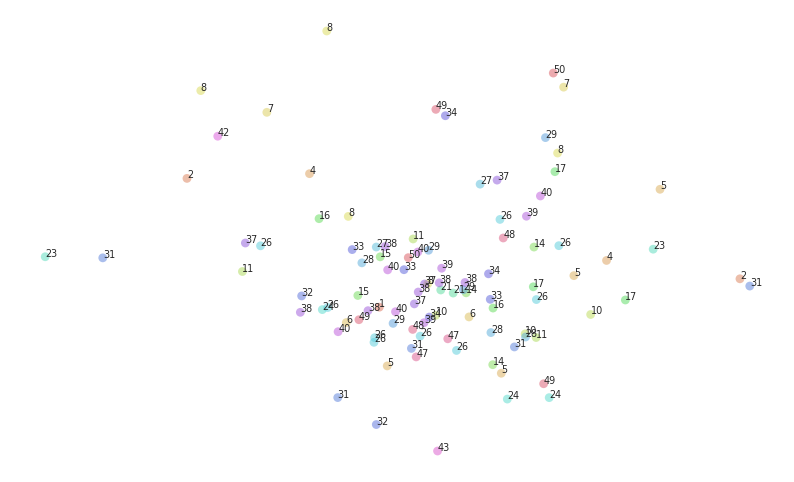

In [44]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 51))
    # We create a scatter plot.
    f = plt.figure(figsize=(10,6))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(int)] )
    for (xi, yi,l) in zip(x[:,0], x[:,1],labels):
        ax.text(xi, yi,l,fontsize='xx-small')

    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')



scatter(X_transformed,labelf)

In [ ]:
!pip install seaborn 

In [4]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd

In [5]:
# import required libraries
import numpy as np
from numpy.linalg import norm

In [6]:
def f(x, y):
    # define two lists or array
    A = np.array(x)
    B = np.array(y)
 
    #print("A:", A)
    #print("B:", B)
 
    # compute cosine similarity
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    #print("Cosine Similarity:", cosine)
    return cosine

In [7]:
matrix_g = np.zeros((X_train_trm.shape[0],X_train_trm.shape[0]))
# we need to iterate over the vector of embedding

for i in range(matrix_g.shape[0]):
    for j in range(X_train_trm.shape[0]):
        matrix_g[i,j] = f(X_train_trm[i],X_train_trm[j])

#>matrix_g
#plt.rcParams["font.family"] = "Times New Roman"

df_cm = pd.DataFrame(matrix_g, index = [i for i in list(df2["indv"])],
                  columns = [i for i in list(df2["indv"])])

NameError: name 'X_train_trm' is not defined

In [53]:
# define two lists or array
A = np.array(X_train_trm[2])
B = np.array(X_train_trm[2])
 
#print("A:", A)
#print("B:", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.99999994


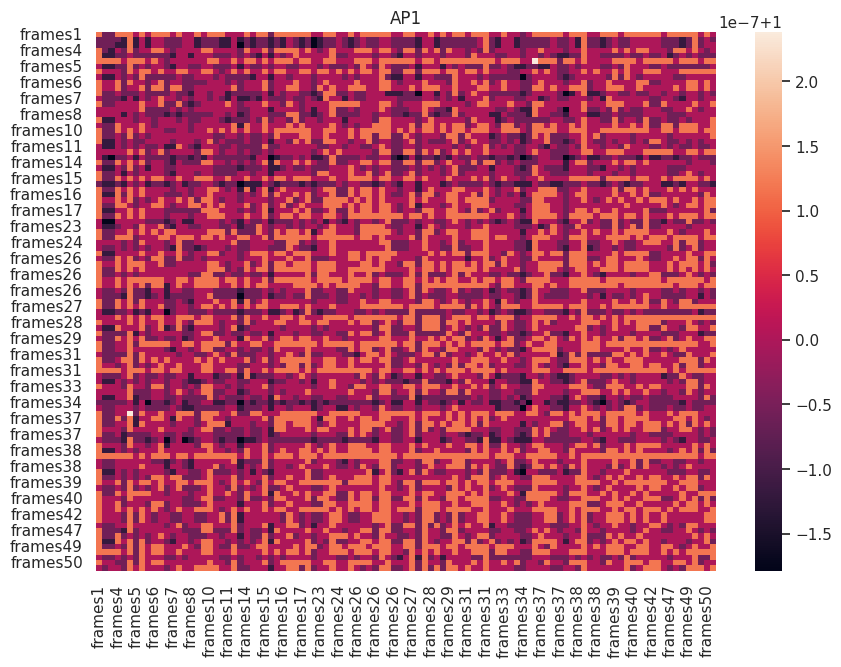

In [51]:
plt.figure(figsize = (10,7))
plt.title('AP1')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
sns.heatmap(df_cm, annot=False)
#plt.savefig('heatmap.png')
plt.savefig('heatmap.pdf')

In [54]:
xs = []
ys = []
dz = []


for i in range(matrix_g.shape[0]):
    for j in range(matrix_g.shape[0]):
        if i != j:
            xs.append(i)
            ys.append(j)
            dz.append(matrix_g[i,j])


In [55]:
df_sm = pd.DataFrame({"sim":dz})
df_sm

,sim
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
10095,1.0
10096,1.0
10097,1.0
10098,1.0


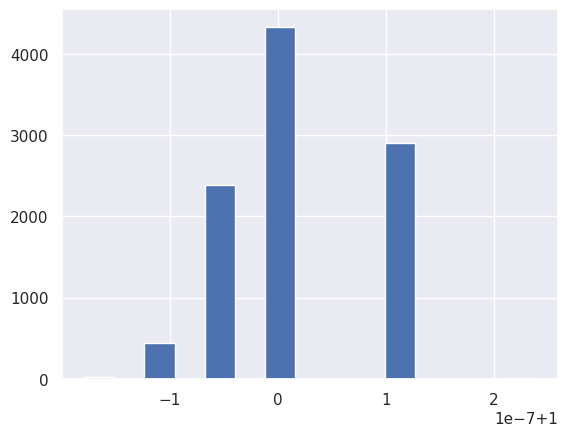

In [56]:
figg = plt.figure()
ax = figg.add_subplot(111)
df_sm["sim"].hist(bins=15)
plt.show()

In [57]:
from PIL import Image 

In [59]:
df_cm.iloc[[2]].values[0]

array([0.99999994, 0.99999994, 0.99999994, 0.99999988, 0.99999988,
       1.00000012, 0.99999988, 1.        , 0.99999988, 1.        ,
       1.        , 0.99999994, 0.99999994, 0.99999994, 1.        ,
       1.        , 0.99999988, 0.99999994, 0.99999994, 0.99999994,
       0.99999988, 0.99999988, 1.        , 0.99999982, 0.99999994,
       0.99999988, 0.99999994, 0.99999994, 0.99999988, 0.99999994,
       0.99999988, 1.        , 0.99999994, 0.99999988, 0.99999994,
       0.99999982, 0.99999988, 0.99999994, 0.99999994, 1.        ,
       0.99999994, 0.99999988, 0.99999994, 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999988, 1.        , 1.        ,
       0.99999988, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 1.        , 1.00000012, 0.99999994,
       0.99999988, 1.        , 1.        , 0.99999988, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 1.     